<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/micro_fluctuations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import time

from astropy.io import fits
from scipy.signal import convolve

from matplotlib.patches import Rectangle
from IPython.display import clear_output
from tqdm import tqdm, trange

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


# А) Карта из GERLUMPH

Вытащим параметры карты из файла mapmeta.dat:

In [ ]:
avmag = 13.0884
avnumrays_perpix = 411.083

res = 10000
length = 25

kappa = 0.72
gamma = 0.1
kappa_c = 0.300

mean_magn = 1./((1.-kappa)**2 - gamma**2)
mean_magn

-2.912359745699709

Откроем карту и перемасштабируем её:

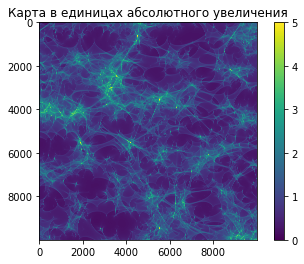

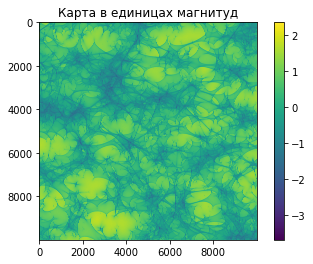

(2.0, -3.0)

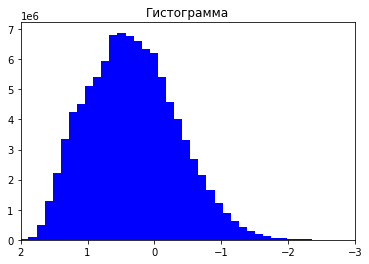

In [ ]:
filename = ("maps/Gerlumph/map.bin")
mapp = open(filename,"rb")
image = np.fromfile(mapp,'i',-1,"")

image = image * avmag / avnumrays_perpix / mean_magn

image = image.reshape(int(res), int(res))

#plt.figure(figsize = (20,20))

plt.imshow(image, vmin=0, vmax = 5)
plt.title('Карта в единицах абсолютного увеличения')
plt.colorbar()
plt.show()

image_mod = -2.5*np.log10(image)

plt.imshow(image_mod)
plt.title('Карта в единицах магнитуд')
plt.colorbar()
plt.show()

plt.hist(image_mod.flatten(), bins=50,color='blue')
plt.title('Гистограмма')
plt.xlim(2,-3)

# Б) Обычная (1000х1000) карта микролинзирования

Карта:

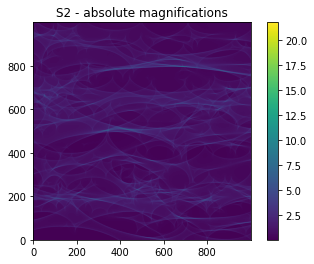

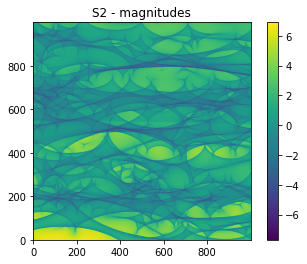

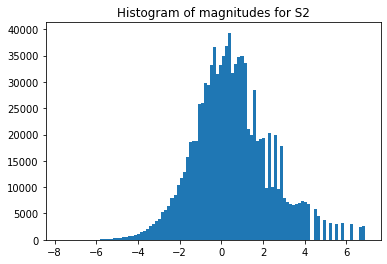

In [18]:
a = fits.open("maps/IRIS314.fits")[0].data
b = 10**(.4*(a-1024)/256.0)

plt.imshow(b, origin='lower')
plt.title("S2 - absolute magnifications")
plt.colorbar()
plt.show()

plt.imshow(-2.5*np.log(b), origin='lower')
plt.title("S2 - magnitudes")
plt.colorbar()
plt.show()

plt.hist(-2.5*np.log(b.flatten()), bins=100)
plt.title("Histogram of magnitudes for S2")
plt.show()

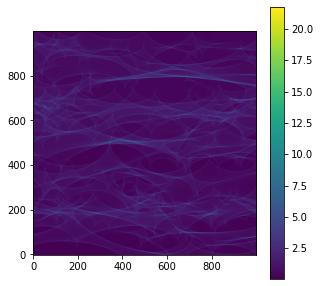

In [ ]:
map_number = 314

image_data = fits.getdata("maps/IRIS"+str(map_number)+".fits")
image = 10**(.4*(image_data-1024)/256.0)

plt.figure(figsize=(5,5))
plt.imshow(image, origin='lower')
plt.colorbar()
plt.show()

#hdul = fits.open("maps/IRIS"+str(map_number)+".fits")  # open a FITS file
#hdr = hdul[0].header  # the primary HDU header
#print('IRIS314:','pixmax0 =',hdr['pixmax0'], 'pixminx =', hdr['x-pos'], 'pixminy =', 
#      hdr['y-pos'], 'pixdif =', hdr['length'], 'fracpixd =', hdr['fracpixd'])

# В) Карта-ступенька

Сформируем карту-"ступеньку".

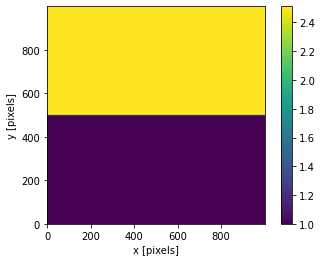

In [ ]:
side = 1000

stupenka_data = np.zeros((side, side))

for i in range(0, side):
    for j in range(0, side):
        if i<int(side/2):
            stupenka_data[i][j]=1024
        else:
            stupenka_data[i][j]=1280

stupenka = 10**(.4*(stupenka_data-1024)/256.)
            
plt.imshow(stupenka, origin='lower')
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

# Определим все необходимые функции

In [ ]:
#Запишем функцию, которая генерирует наш фильтр-кружок (маску). Входные параметры:
#rad_pix - радиус фильтра в пикселях (целое число).
#rads, ld - таблично заданное распределение яркости вдоль радиуса фильтра-кружка.

def createMyMask(rad_pix, rads, ld):
    
    w = 2*rad_pix
    h = 2*rad_pix
    
    center = [rad_pix, rad_pix]
    
    dist_from_center = np.zeros((w, h))
    z = dist_from_center*0    
    
    new_grid = rads/np.max(rads) #перенормируем заданное распределение на радиус фильтра (на всякий случай)
    new_grid = new_grid * rad_pix
    
    delta=1 
    x = np.arange(0, w, delta)
    y = np.arange(0, h, delta)

    Y, X = np.meshgrid(x,y)

    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
    
    for i in range(0, w):
        for j in range(0, h):
            if dist_from_center[i][j] < rad_pix:
                z[i][j] = np.interp(np.around(dist_from_center[i][j]), new_grid, ld)
            else:
                z[i][j] = 0
    
    return z#/np.sum(z)

#Функция, которая вырезает кружок из карты.

def cut_circle(image, center, rad_pix, graphics):
    
    kusok = np.zeros((2*rad_pix, 2*rad_pix))
    
    for i in range(center[1]-rad_pix, center[1]+rad_pix):
        for j in range(center[0]-rad_pix, center[0]+rad_pix):
             kusok[i - (center[1]-rad_pix)][j - (center[0]-rad_pix)] = image[i][j]
    
    circle_ones = createMyMask(rad_pix, np.arange(0, rad_pix, 1), np.ones(rad_pix))
    mult = np.multiply(circle_ones, kusok)
    
    if graphics:
        
        plt.imshow(image, origin='lower')
        plt.colorbar()
        plt.gca().add_patch( Rectangle( (center[0]-rad_pix, center[1]-rad_pix), 2*rad_pix, 2*rad_pix, fill=None))
        plt.show()

        plt.imshow(kusok, origin='lower')
        plt.colorbar()
        plt.show()

        plt.imshow(mult, origin='lower')
        plt.colorbar()
        plt.show()
    
    return mult

#Считаем флуктуации от микролинзирования

#По какому закону расширяется сверхновая?

def radius_in_time(tau):
  
  velocity = 1  #пусть у нас будет такой коэффициент линейной связи радиуса и времени
  r_0 = 2      #начальный радиус не может быть нулевым

  return int(velocity * tau + r_0)

#Функция, которая считает флуктуации от микролинзирования. Входные параметры:
#mapp - карта микролинзирования,
#cntr - точка, в которой сверхновая начинает расширение,
#max_radius - максимальный радиус сверхновой,
#time_grid - массив с сеткой по времени,
#rads_grid - двумерный массив с сеткой по координатам вдоль радиуса для каждого момента времени,
#light_grid_gauss, light_grid_flat - двумерный массив, содержащий значения яркости вдоль радиуса для гаусового источника и для точечного соответственно для каждого момента времени,
#Graphics - выводит или не выводит промежуточные иллюстрации,
#dividebymedian - деление значений флуктуаций на медианное,
#plot - график (как в sntd).

def micro(mapp, cntr, max_radius, time_grid, rads_grid, light_grid_gauss, 
          light_grid_flat, Graphics=False, dividebymedian=True, plot=True):

    #cформируем рабочие массивы

    mu_gauss = np.zeros(len(time_grid))
    mu_flat = np.zeros(len(time_grid))
    
    t_0 = time.time() #оценка времени выполнения блока
    
    for t in range(0, len(time_grid)):

        radius_now = radius_in_time(time_grid[t])

        if radius_now < max_radius:
            
            if Graphics == True:
              print('Radius is', radius_now, 'pixels now. Profile at this moment:')
              #plt.plot(rads_grid[t][1:radius_now], light_grid_flat[t][1:radius_now])
              plt.plot(rads_grid[t][1:radius_now], light_grid_gauss[t][1:radius_now])
              plt.xlim((0,100))
              plt.show()

            mask_now_gauss = createMyMask(radius_now, rads_grid[t][1:radius_now], light_grid_gauss[t][1:radius_now])
            mask_now_flat = createMyMask(radius_now, rads_grid[t][1:radius_now], light_grid_flat[t][1:radius_now])

            #if Graphics == True:
            #  plt.imshow(mask_now_gauss)
            #  plt.colorbar()
            #  plt.show()

            #svertka_now_gauss = convolve(image, mask_now_gauss, mode='same') 
            #svertka_now_flat = convolve(image, mask_now_flat, mode='same')

            #plt.imshow(svertka_now_gauss)
            #plt.colorbar()
            #plt.show()        

            cut_now = cut_circle(mapp, cntr, radius_now, graphics=False)

            #if Graphics == True:
            #  plt.imshow(cut_now)
            #  plt.colorbar()
            #  plt.show()

            mult_gauss = np.multiply(cut_now, mask_now_gauss)
            mult_flat = np.multiply(cut_now, mask_now_flat)

            #if Graphics == True:
            #  plt.imshow(mult_gauss)
            #  plt.colorbar()
            #  plt.show()

            mu_gauss[t] = float(mult_gauss.sum())/float(mask_now_gauss.sum())
            mu_flat[t] = float(mult_flat.sum())/float(mask_now_flat.sum())

            #print(velocity, time_grid[t], r_0, radius_now)
            clear_output()
            print(round( t/len(time_grid)*100 ), '% completed.', round( time.time() - t_0 ), 'seconds passed')

        else:
            print('Ooops, radius_now =', radius_now,'>',max_radius) #ограничим радиус сверху
            sys.exit()

    clear_output()
    print('Completed in', round( time.time() - t_0 ), 'seconds')

    if plot:

        plt.figure(figsize=(8,8))
        plt.imshow(image, origin='lower')
        plt.gca().add_patch( plt.Circle(center, max_radius, color='red', alpha=0.3) )
        plt.colorbar()
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(time_grid, -2.5*np.log10(mu_gauss), label='gauss')
        plt.plot(time_grid, -2.5*np.log10(mu_flat), label='flat')
        #plt.axhline(np.median(mu_gauss), color='r', linestyle='--', label='gauss mean')
        #plt.axhline(np.median(mu_flat), color='g', linestyle='--', label='flat mean')
        plt.gca().invert_yaxis()
        plt.xlabel('Time (arbitrary units)')
        plt.ylabel('$\Delta m$ due microlensing only')
        plt.legend()
        plt.grid()
        plt.show()

    if dividebymedian:
      return -2.5*np.log10(mu_gauss/np.median(mu_gauss)), -2.5*np.log10(mu_flat/np.median(mu_flat))
    else:
      return -2.5*np.log10(mu_gauss), -2.5*np.log10(mu_flat)

# Проверка функций

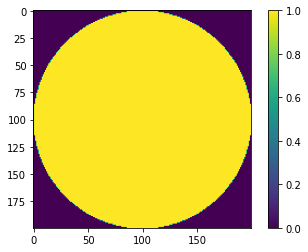

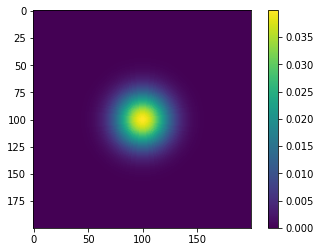

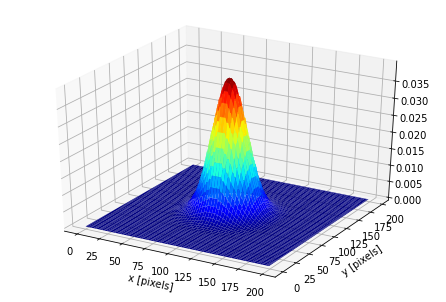

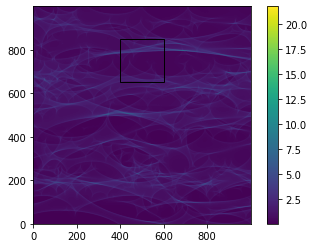

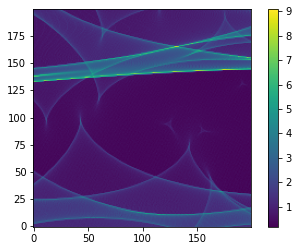

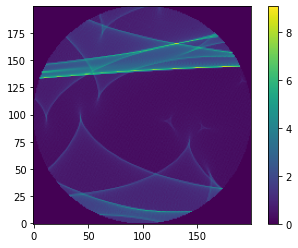

In [ ]:
#Проверим её на плоском и на гауссовом источниках

try_radius = 100
try_rads = np.arange(0, 60, 1)

try_ld_flat = np.ones(len(try_rads))
try_mask_flat = createMyMask(try_radius, try_rads, try_ld_flat)

plt.imshow(try_mask_flat)
plt.colorbar()
plt.show()

try_sigma = 10
try_ld_gauss = (1/np.sqrt(2*np.pi)/try_sigma)*np.exp(-try_rads**2/2/try_sigma**2)

try_mask_gauss = createMyMask(try_radius, try_rads, try_ld_gauss)

plt.imshow(try_mask_gauss)
plt.colorbar()
plt.show()

#гауссовый источник дополнительно нарисуем в 3D

import pylab
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

x = np.arange(0,2*try_radius, 1)
y = np.arange(0,2*try_radius, 1)

X,Y = np.meshgrid(x, y)

fig = pylab.figure()
axes = Axes3D(fig)

axes.plot_surface(X,Y, try_mask_gauss, rstride=3, cstride=3, cmap=cm.jet)
pylab.xlabel('x [pixels]')
pylab.ylabel('y [pixels]')

pylab.show()

#вырежем кружок из карты

cut = cut_circle(image, (500, 750), 100, graphics=True)

#plt.imshow(cut)
#plt.colorbar()
#plt.show()

# Рабочий процесс

Входные данные:

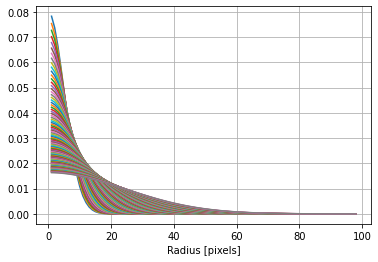

In [ ]:
max_time = 98

max_radius = 100

time_grid = np.arange(0, max_time, 1)

#зададим данные (распределения яркости в различные моменты времени)

rads_grid = np.zeros( (len(time_grid), max_radius) )
light_grid_gauss = np.zeros( (len(time_grid), max_radius) )
light_grid_flat = np.ones( (len(time_grid), max_radius) )/len(time_grid)

for j in range( 0, len(time_grid) ):
    for k in range( 0, max_radius ):

        rads_grid[j][k] = k 

        sigma = 5 + time_grid[j]/5 #пускай для начала зависимость будет такой
       
        light_grid_gauss[j][k] = (1/np.sqrt(2*np.pi)/sigma)*np.exp(-rads_grid[j][k]**2/2/sigma**2)    
        
    plt.plot(rads_grid[j][1:k], light_grid_gauss[j][1:k])
    #plt.plot(rads_grid[j][1:k], light_grid_flat[j][1:k])
    
plt.grid()
plt.xlabel('Radius [pixels]')
plt.show()

In [ ]:
attempts = 10

everything = np.zeros(2+1+3*len(time_grid))

for i in range(attempts):

  xx = 100 + np.int(800*np.random.random())
  yy = 100 + np.int(800*np.random.random())
  center = (xx, yy)

  dm_gauss, dm_flat = micro(image, center, max_radius, time_grid, rads_grid, light_grid_gauss, light_grid_flat, dividebymedian=False, plot=False)

  new_row = [*center, len(time_grid), *time_grid, *dm_gauss, *dm_flat]

  everything = np.vstack( (everything, new_row) )

Completed in 33 seconds


In [ ]:
pd.DataFrame(everything).drop(0)#.to_csv('data/micro_data314.csv', index=False)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296
1,109.0,657.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.660297,-0.660566,-0.661261,-0.660393,-0.657941,-0.655176,-0.651912,-0.648889,-0.645948,-0.642069,-0.638805,-0.634992,-0.631534,-0.628077,-0.624538,-0.621932,-0.619677,-0.616782,-0.613973,-0.611402,-0.608562,-0.605733,-0.602742,-0.599501,-0.596158,-0.592538,-0.588916,-0.585705,-0.583095,-0.579867,-0.575910,-0.572141,-0.568420,-0.565286,-0.562738,-0.560286,-0.557855,-0.555802,-0.553524,-0.551409
2,426.0,700.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,0.068095,0.068283,0.069518,0.069919,0.070503,0.070918,0.071191,0.071420,0.071773,0.072031,0.071963,0.071657,0.071491,0.070931,0.070052,0.068448,0.067039,0.065237,0.062566,0.060973,0.060054,0.059516,0.059326,0.059639,0.059899,0.058055,0.050794,0.042935,0.036166,0.029616,0.021895,0.012267,0.003969,-0.003508,-0.010475,-0.016736,-0.022551,-0.028526,-0.035739,-0.041728
3,391.0,773.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.022974,-0.017207,-0.014989,-0.013304,-0.011955,-0.010395,-0.008699,-0.007473,-0.006187,-0.005463,-0.005027,-0.003589,-0.002385,-0.000504,0.000768,0.002536,0.003980,0.005768,0.007355,0.008520,0.009766,0.010829,0.011417,0.011271,0.011141,0.012205,0.013587,0.014801,0.016338,0.017661,0.019698,0.021211,0.022903,0.024632,0.026003,0.027821,0.029060,0.030466,0.032045,0.030757
4,867.0,214.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.345917,-0.343358,-0.340331,-0.336998,-0.332973,-0.328583,-0.323674,-0.318709,-0.313717,-0.308238,-0.303453,-0.299169,-0.294512,-0.289037,-0.283067,-0.277222,-0.271033,-0.265261,-0.259282,-0.253308,-0.246703,-0.240071,-0.234156,-0.227234,-0.221269,-0.214741,-0.208586,-0.202606,-0.195982,-0.190235,-0.183412,-0.177738,-0.172180,-0.166200,-0.160280,-0.153991,-0.148210,-0.142363,-0.136210,-0.130665
5,785.0,142.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.119608,-0.121926,-0.120955,-0.120892,-0.120576,-0.119002,-0.117938,-0.116318,-0.114631,-0.112790,-0.110732,-0.109795,-0.108074,-0.106486,-0.103899,-0.101998,-0.099646,-0.097757,-0.096312,-0.094959,-0.093224,-0.091264,-0.089296,-0.086946,-0.085019,-0.083259,-0.082122,-0.081263,-0.080217,-0.077959,-0.075924,-0.073551,-0.071096,-0.068332,-0.066156,-0.063569,-0.062481,-0.061905,-0.062281,-0.062430
6,446.0,526.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,...,-0.318524,-0.307009,-0.296125,-0.285349,-0.274682,-0.264558,-0.253206,-0.248566,-0.247342,-0.247592,-0.244886,-0.240683,-0.236539,-0.231539,-0.226952,-0.222167,-0.217229,-0.212463,-0.206996,-0.202644,-0.197841,-0.193389,-0.188980,-0.184240,-0.179913,-0.175056,-0.170205,-0.165843,-0.161062,-0.156859,-0.151830,-0.147780,-0.143744,-0.139777,-0.136291,-0.132606,-0.129503,-0.126539,-0.124740,-0.123943
7,512.0,726.0,98.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,..

In [ ]:
fluct = everything
length = 98

xxs = fluct[:, 0]
yys = fluct[:, 1]
lengths = fluct[:,2].astype(int)
time_grids = fluct[:, 3:3+length]
dm_gausss = fluct[:, 3+length:3+2*length]
dm_flats = fluct[:, 3+2*length:3+3*length]

Number 0 , center = ( 0.0 , 0.0 )


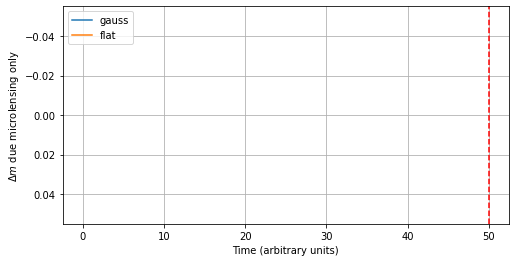

Number 1 , center = ( 109.0 , 657.0 )


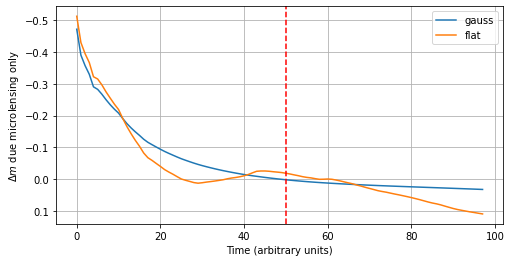

Number 2 , center = ( 426.0 , 700.0 )


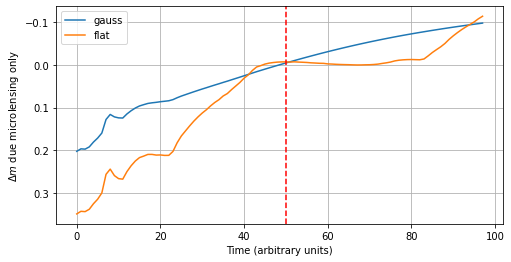

Number 3 , center = ( 391.0 , 773.0 )


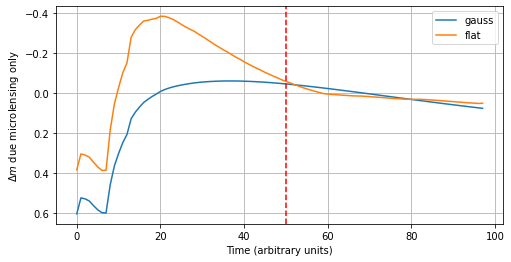

Number 4 , center = ( 867.0 , 214.0 )


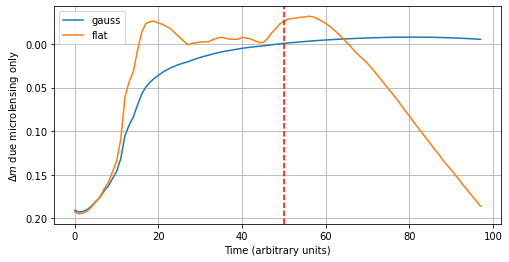

Number 5 , center = ( 785.0 , 142.0 )


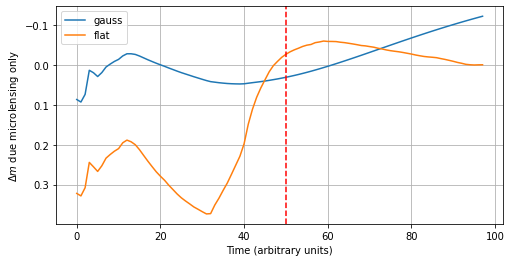

Number 6 , center = ( 446.0 , 526.0 )


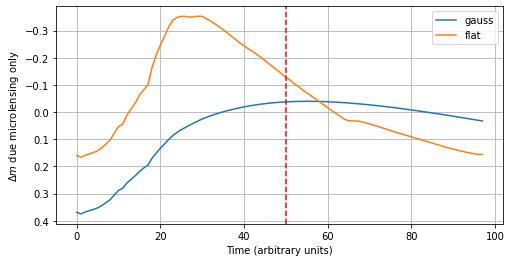

Number 7 , center = ( 512.0 , 726.0 )


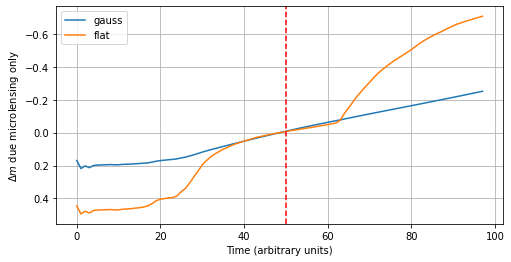

Number 8 , center = ( 819.0 , 843.0 )


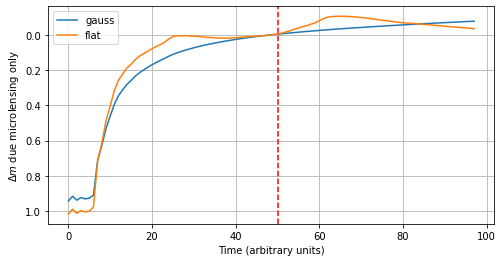

Number 9 , center = ( 874.0 , 707.0 )


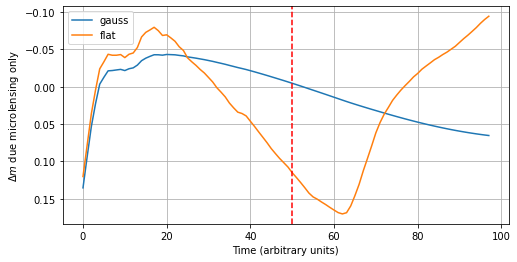

Number 10 , center = ( 192.0 , 144.0 )


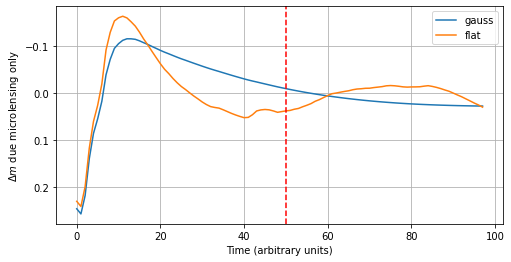

In [ ]:
for j in range(0, len(fluct)):

  xx = xxs[j]
  yy = yys[j]
  length = lengths[j]
  time_grid = time_grids[j]
  dm_gauss = dm_gausss[j]
  dm_flat = dm_flats[j]
  
  print('Number', j, ', center = (', xx, ',', yy,')')
  
  plt.figure(figsize=(8,4))
  plt.plot(time_grid, dm_gauss - np.median(dm_gauss), label='gauss')
  plt.plot(time_grid, dm_flat - np.median(dm_flat), label='flat')
  plt.axvline(50, color='r', linestyle = '--')
  #plt.axhline(np.median(dm_gauss), color='r', linestyle='--', label='gauss mean')
  #plt.axhline(np.median(dm_flat), color='g', linestyle='--', label='flat mean')
  plt.gca().invert_yaxis()
  plt.xlabel('Time (arbitrary units)')
  plt.ylabel('$\Delta m$ due microlensing only')
  #plt.title('FLAT')
  plt.legend()
  plt.grid()
  plt.show()

# Сравниваем результаты с SNTD (для карт 1000х1000)

In [ ]:
! pip install sntd

clear_output()

Сверим полученные результаты с работой SNTD.

Assuming velocity is in km/s.


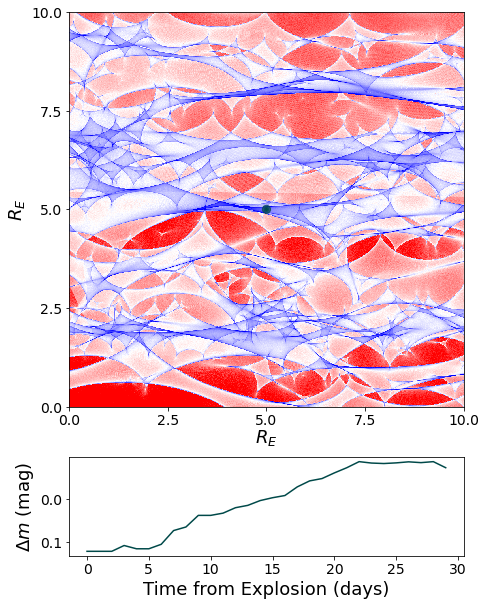

In [ ]:
import sntd

center = (500,500)

time1,dmag1 = sntd.microcaustic_field_to_curve(field = image_data,time=np.arange(0, 30,1), ax=None, zl=.541,zs=1.488, 
                                           velocity=20000,width_in_einstein_radii=10, plot=True, loc=center, rescale=True)
plt.show()

Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.
Assuming velocity is in km/s.


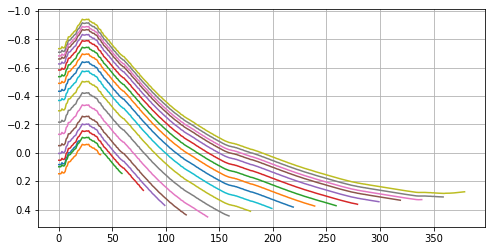

In [ ]:
plt.figure(figsize=(8,4))
plt.gca().invert_yaxis()
plt.grid()

sizes = 20

for i in range(1, sizes):

  center = (500, 500)

  time1,dmag1 = sntd.microcaustic_field_to_curve(field = image_data,time=np.arange(0, 20*i,1), ax=None, zl=.541,zs=1.488, 
                                                  velocity=20000,width_in_einstein_radii=10, plot=False, loc=center, rescale=True)

  plt.plot(time1, -2.5*np.log10(dmag1))

plt.savefig('check.jpg')
plt.show()

Для равномерно засвеченного источника получилось похоже. Сравним флуктуации поточечно.

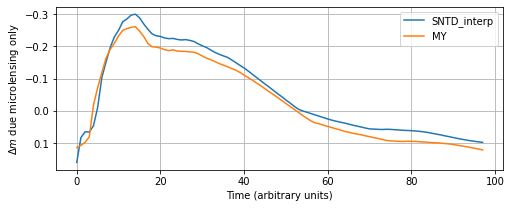

In [ ]:
plt.figure(figsize=(8,3))

factor = len(time1)/len(time_grid) 

sntd_to_my = np.interp(time_grid*factor, time1, -2.5*np.log10(dmag1))

plt.plot(time_grid, sntd_to_my, label='SNTD_interp')
plt.plot(time_grid, dm_flat, label='MY')

plt.gca().invert_yaxis()
plt.xlabel('Time (arbitrary units)')
plt.ylabel('$\Delta m$ due microlensing only')
plt.grid()
plt.legend()
plt.savefig('1.png')
plt.show()

#plt.show()